In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
import openslide
import cv2  

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [92]:
cat_train = {'BAL_Cat_Turnbull blue_13.svs': {"coordinates": []},#{ "xmin":16419, "ymin": 16787}, 
                              'BAL_Cat_Turnbull blue_6.svs': {"coordinates": []},#{ "xmin":14189, "ymin": 10303}, 
                              'BAL_Cat_Turnbull blue_12.svs': {"coordinates": []},#{ "xmin":15758, "ymin": 18937},
                              'BAL_Cat_Turnbull blue_14.svs': {"coordinates": []},#{ "xmin":16960, "ymin": 12381}, 
                              'BAL_Cat_Turnbull blue_2.svs': {"coordinates": []}}#{ "xmin":19941, "ymin": 16538}}

cat_val = {'BAL_Cat_Turnbull blue_1.svs': {"coordinates": []},#{ "xmin":13648, "ymin": 9247},
                              'BAL_Cat_Turnbull blue_10.svs': {"coordinates": []}}#{ "xmin":25786, "ymin": 17531}}

In [93]:
equine_train = {"03_EIPH_566933 R Turnbull blue.svs": {"coordinates": []},#{ "xmin":25519, "ymin": 19441}, 
                           "22_EIPH_575216 Turnbull blue.svs": {"coordinates": []},#{ "xmin":9480, "ymin": 13123},
                              "27_EIPH_571557 berliner blau.svs":  {"coordinates": []},#{ "xmin":14206, "ymin": 8571}, 
                              "15_EIPH_568320 Turnbull blue.svs":  {"coordinates": []},#{ "xmin":21089, "ymin": 16296},
                               "17_EIPH_575796 Berliner Blau.svs":  {"coordinates": []}}#{ "xmin":24380, "ymin": 13168}}

equine_val = {"07_EIPH_574882 left lung Turnbull blue.svs":  {"coordinates": []},#{ "xmin":26212, "ymin": 16510}, 
                            "31_EIPH_568354 Berliner Blau.svs":  {"coordinates": []}}#{ "xmin":21846, "ymin": 27573}}

In [94]:
human_train = {'2707_20 TB BAL Human neu.svs':  {"coordinates": []},#{ "xmin":13536, "ymin": 7320}, 
                              '10080_19 humane BAL Berliner Blau-001.svs':  {"coordinates": []},#{ "xmin":16163, "ymin": 16157}, 
                              '10052_19 humane BAL Berliner Blau-001.svs':  {"coordinates": []},#{ "xmin":14051, "ymin": 19716},
                              '10835_19 humane BAL Berliner Blau.svs':  {"coordinates": []},#{ "xmin":12557, "ymin": 23663}, 
                              '10227_19 humane BAL Berliner Blau.svs':  {"coordinates": []}}#{ "xmin":8116, "ymin": 7836}}

human_val = {'11480_19 humane BAL Berliner Blau.svs':  {"coordinates": []},#{ "xmin":14333, "ymin": 22500},
                              '2702_20 BB Human BAL-001.svs':  {"coordinates": []}}#{ "xmin":19693, "ymin": 17456}}

In [9]:
grade_list = [0, 1]

df = pd.read_pickle("../EIPH_Screening_Annotations.pkl")
df = df[df["grade"].isin(grade_list)]
df = df[df["image_name"].isin(list(cat_train.keys())
                              +list(cat_val.keys())
                              +list(equine_train.keys())
                              +list(equine_val.keys())
                              +list(human_train.keys())
                              +list(human_val.keys()))]

#df["image_name"] = [name.replace("tiff","svs") for name in df["image_name"]]
df.head()

id  image_id  image_set species                   image_name  \
0  1049539      3512        222     Cat  BAL_Cat_Turnbull blue_1.svs   
1  1049548      3512        222     Cat  BAL_Cat_Turnbull blue_1.svs   
2  1049551      3512        222     Cat  BAL_Cat_Turnbull blue_1.svs   
3  1049568      3512        222     Cat  BAL_Cat_Turnbull blue_1.svs   
4  1049624      3512        222     Cat  BAL_Cat_Turnbull blue_1.svs   

  image_type  grade                                             vector  \
0   Turnbull      0  {'x1': 9903.0, 'x2': 10029.0, 'y1': 5508.0, 'y...   
1   Turnbull      0  {'x1': 12243.0, 'x2': 12375.0, 'y1': 14740.0, ...   
2   Turnbull      0  {'x1': 20253.0, 'x2': 20366.0, 'y1': 4149.0, '...   
3   Turnbull      0  {'x1': 2906.0, 'x2': 3030.0, 'y1': 16767.0, 'y...   
4   Turnbull      0  {'x1': 11203.0, 'x2': 11328.0, 'y1': 7867.0, '...   

                      unique_identifier  user_id  deleted  last_editor  \
0  875aab61-3f1f-429a-a053-f87aba6c99da        1    False            1   
1  d718f087-7a46-4e22-8610-ba5f82d04818        1    False            1   
2  7e9cc21f-4a51-4d12-99dd-daffa3e6f368        1    False            1   
3  0a546034-021b-4739-82bf-b09c7a5226d5        1    False            1   
4  52536c1e-32f3-4a15-9c08-0350c0ad1b2b        1    False            1   

  data_set_name   version  
0         SDATA  Screened  
1         SDATA  Screened  
2         SDATA  Screened  
3         SDATA  Screened  
4         SDATA  Screened

In [10]:
df["x1"] = [vector["x1"] for vector in df["vector"]]
df["y1"] = [vector["y1"] for vector in df["vector"]]
df["x2"] = [vector["x2"] for vector in df["vector"]]
df["y2"] = [vector["y2"] for vector in df["vector"]]

df["cx"] = df["x2"] - (df["x2"] - df["x1"])
df["cy"] = df["y2"] - (df["y2"] - df["y1"])
df.head()

id  image_id  image_set species                   image_name  \
0  1049539      3512        222     Cat  BAL_Cat_Turnbull blue_1.svs   
1  1049548      3512        222     Cat  BAL_Cat_Turnbull blue_1.svs   
2  1049551      3512        222     Cat  BAL_Cat_Turnbull blue_1.svs   
3  1049568      3512        222     Cat  BAL_Cat_Turnbull blue_1.svs   
4  1049624      3512        222     Cat  BAL_Cat_Turnbull blue_1.svs   

  image_type  grade                                             vector  \
0   Turnbull      0  {'x1': 9903.0, 'x2': 10029.0, 'y1': 5508.0, 'y...   
1   Turnbull      0  {'x1': 12243.0, 'x2': 12375.0, 'y1': 14740.0, ...   
2   Turnbull      0  {'x1': 20253.0, 'x2': 20366.0, 'y1': 4149.0, '...   
3   Turnbull      0  {'x1': 2906.0, 'x2': 3030.0, 'y1': 16767.0, 'y...   
4   Turnbull      0  {'x1': 11203.0, 'x2': 11328.0, 'y1': 7867.0, '...   

                      unique_identifier  user_id  deleted  last_editor  \
0  875aab61-3f1f-429a-a053-f87aba6c99da        1    False            1   
1  d718f087-7a46-4e22-8610-ba5f82d04818        1    False            1   
2  7e9cc21f-4a51-4d12-99dd-daffa3e6f368        1    False            1   
3  0a546034-021b-4739-82bf-b09c7a5226d5        1    False            1   
4  52536c1e-32f3-4a15-9c08-0350c0ad1b2b        1    False            1   

  data_set_name   version       x1       y1       x2       y2       cx  \
0         SDATA  Screened   9903.0   5508.0  10029.0   5637.0   9903.0   
1         SDATA  Screened  12243.0  14740.0  12375.0  14872.0  12243.0   
2         SDATA  Screened  20253.0   4149.0  20366.0   4263.0  20253.0   
3         SDATA  Screened   2906.0  16767.0   3030.0  16891.0   2906.0   
4         SDATA  Screened  11203.0   7867.0  11328.0   7992.0  11203.0   

        cy  
0   5508.0  
1  14740.0  
2   4149.0  
3  16767.0  
4   7867.0

In [95]:
size = 1024

data = []
for image_name in tqdm(df["image_name"].unique()):
    #print(image_name)
    
    image_data = []
    annos = df[df["image_name"] == image_name]
    for xmin in range(0, 50000, size):
        for ymin in range(0, 50000, size):
            
            temp_annos = annos[(annos["cx"] > xmin) & (annos["cx"] < xmin + size)]
            temp_annos = temp_annos[(temp_annos["cy"] > ymin) & (temp_annos["cy"] < ymin + size)]
            
            if len(temp_annos) > 3:
                image_data.append([image_name, xmin, ymin, len(temp_annos)])
            
            
    image_data.sort(key=lambda  row: row[3], reverse=True)
    
    for _, xmin, ymin, _ in image_data[:3]:
        if image_name in cat_train: 
            cat_train[image_name]["coordinates"].append([xmin, ymin])
        if image_name in cat_val: 
            cat_val[image_name]["coordinates"].append([xmin, ymin])

        if image_name in equine_train: 
            equine_train[image_name]["coordinates"].append([xmin, ymin])
        if image_name in equine_val: 
            equine_val[image_name]["coordinates"].append([xmin, ymin])

        if image_name in human_train: 
            human_train[image_name]["coordinates"].append([xmin, ymin])
        if image_name in human_val: 
            human_val[image_name]["coordinates"].append([xmin, ymin])   
            
    
    data.extend(image_data[:3])     
    
        
data = pd.DataFrame(data, columns=["name", "xmin", "ymin", "count"])
data.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:10<00:00,  3.34s/it]


name   xmin   ymin  count
0  BAL_Cat_Turnbull blue_1.svs   7168   7168     29
1  BAL_Cat_Turnbull blue_1.svs  11264   6144     25
2  BAL_Cat_Turnbull blue_1.svs   7168   6144     23
3  BAL_Cat_Turnbull blue_2.svs   9216  24576      5
4  BAL_Cat_Turnbull blue_2.svs  28672  15360      5

In [96]:
cat_val["BAL_Cat_Turnbull blue_1.svs"]

{'coordinates': [[7168, 7168], [11264, 6144], [7168, 6144]]}

In [55]:
len(data["name"].unique())

21

In [56]:
slides_path = Path("../../Slides")
files = {slide.name: slide for slide in slides_path.rglob("*.svs")}
list(files)[:5]

['BAL_Cat_Turnbull blue_1.svs',
 'BAL_Cat_Turnbull blue_10.svs',
 'BAL_Cat_Turnbull blue_11.svs',
 'BAL_Cat_Turnbull blue_12.svs',
 'BAL_Cat_Turnbull blue_13.svs']

In [57]:
def draw_results_mpl(patch, annos, linewidth=3):
    
    f = plt.figure(figsize=(24,24))
    ax = f.subplots(1)
    
    ax.imshow(patch)
    
    for x1, y1, x2, y2, grade in zip(annos["x1"], annos["y1"], annos["x2"], annos["y2"], annos["grade"]):
        
        color = 'r'
        if int(grade) == 0:
            color = 'g'
        elif int(grade) == 1:
            color = 'b'
        elif int(grade) == 2:
            color = 'y'
        elif int(grade) == 3:
            color = 'm'

        rect = patches.Rectangle((x1, y1),y2-y1, x2-x1, linewidth=linewidth,edgecolor=color,facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()

In [58]:
import matplotlib
matplotlib.colors.to_rgba("m")

(0.75, 0.0, 0.75, 1)

In [59]:
def draw_results(image_infos, linewidth=3):
    
    patch = np.array(np.array(image_infos["patch"])[:, :, :3])
    annos = image_infos["annos"]
    
    for x1, y1, x2, y2, grade in zip(annos["x1"], annos["y1"], annos["x2"], annos["y2"], annos["grade"]):
        
        color = (0, 0, 255) #BGR
        if int(grade) == 0:
            color = (0, 128, 0)
        elif int(grade) == 1:
            color = (255, 0, 0)
        elif int(grade) == 2:
            color = (0, 128, 128)
        elif int(grade) == 3:
            color = (128,  128)
            
        patch = cv2.rectangle(patch, (int(x1), int(y1)), (int(x2), int(y2)), color, linewidth) 
    
    return patch

In [84]:
def extract_information(image_dict, size=1024, level=0, index=0):
    
    for image_name, image_infos in image_dict.items():
    
        #xmin = image_infos["xmin"] 
        #ymin = image_infos["ymin"]
        xmin, ymin = image_infos["coordinates"][index]

        file_name = str(files[image_name])
        image_dict[image_name]["filename"] = file_name

        slide = openslide.OpenSlide(filename=file_name)

        patch = slide.read_region(location=(xmin, ymin), level=level, size=(size, size))

        image_dict[image_name]["patch"] = patch 

        annos = df[df["image_name"] == image_name]
        annos = annos[(annos["cx"] > xmin) & (annos["cx"] < xmin + size)]
        annos = annos[(annos["cy"] > ymin) & (annos["cy"] < ymin + size)]

        annos["x1"] = annos["x1"] - xmin
        annos["y1"] = annos["y1"] - ymin
        annos["x2"] = annos["x2"] - xmin
        annos["y2"] = annos["y2"] - ymin

        annos["cx"] = annos["cx"] - xmin
        annos["cy"] = annos["cy"] - ymin

        image_dict[image_name]["annos"] = annos 
        
    return image_dict

In [85]:
def combine_images(patch_l, patch_r, size=1024):
    
    triangle_cnt = np.array([(0,0), (size, size), (0, size)])

    mask = np.zeros(shape=patch_l.shape, dtype=np.uint8)
    
    cv2.drawContours(mask, [triangle_cnt], 0, (255, 255, 255), -1)
    
    result = np.ma.where(mask > 0, patch_l, patch_r)
    
    return result

In [86]:
def create_split_image(source_domain, target_domain):
    
    source_patch, target_patch = draw_results(source_domain), draw_results(target_domain)
    
    return combine_images(np.array(source_patch), np.array(target_patch))

In [149]:
cat_train = extract_information(cat_train, index=0)
cat_val = extract_information(cat_val, index=0)


equine_train = extract_information(equine_train, index=0)
equine_val = extract_information(equine_val, index=0)


human_train = extract_information(human_train, index=0)
human_val = extract_information(human_val, index=0)

In [123]:
cat_infos = cat_train["BAL_Cat_Turnbull blue_13.svs"]
human_infos = human_val["11480_19 humane BAL Berliner Blau.svs"]

In [124]:
cat_patch, human_patch = draw_results(cat_infos), draw_results(human_infos)

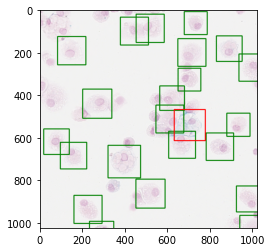

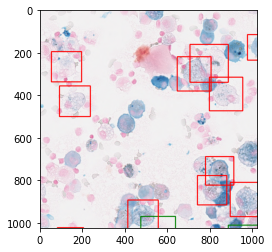

In [125]:
plt.imshow(cat_patch)
plt.show()
plt.imshow(human_patch)

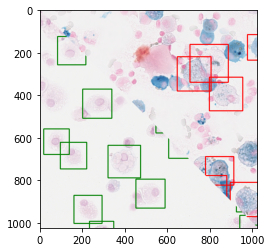

In [107]:
temp = combine_images(np.array(cat_patch), np.array(human_patch))
plt.imshow(temp)

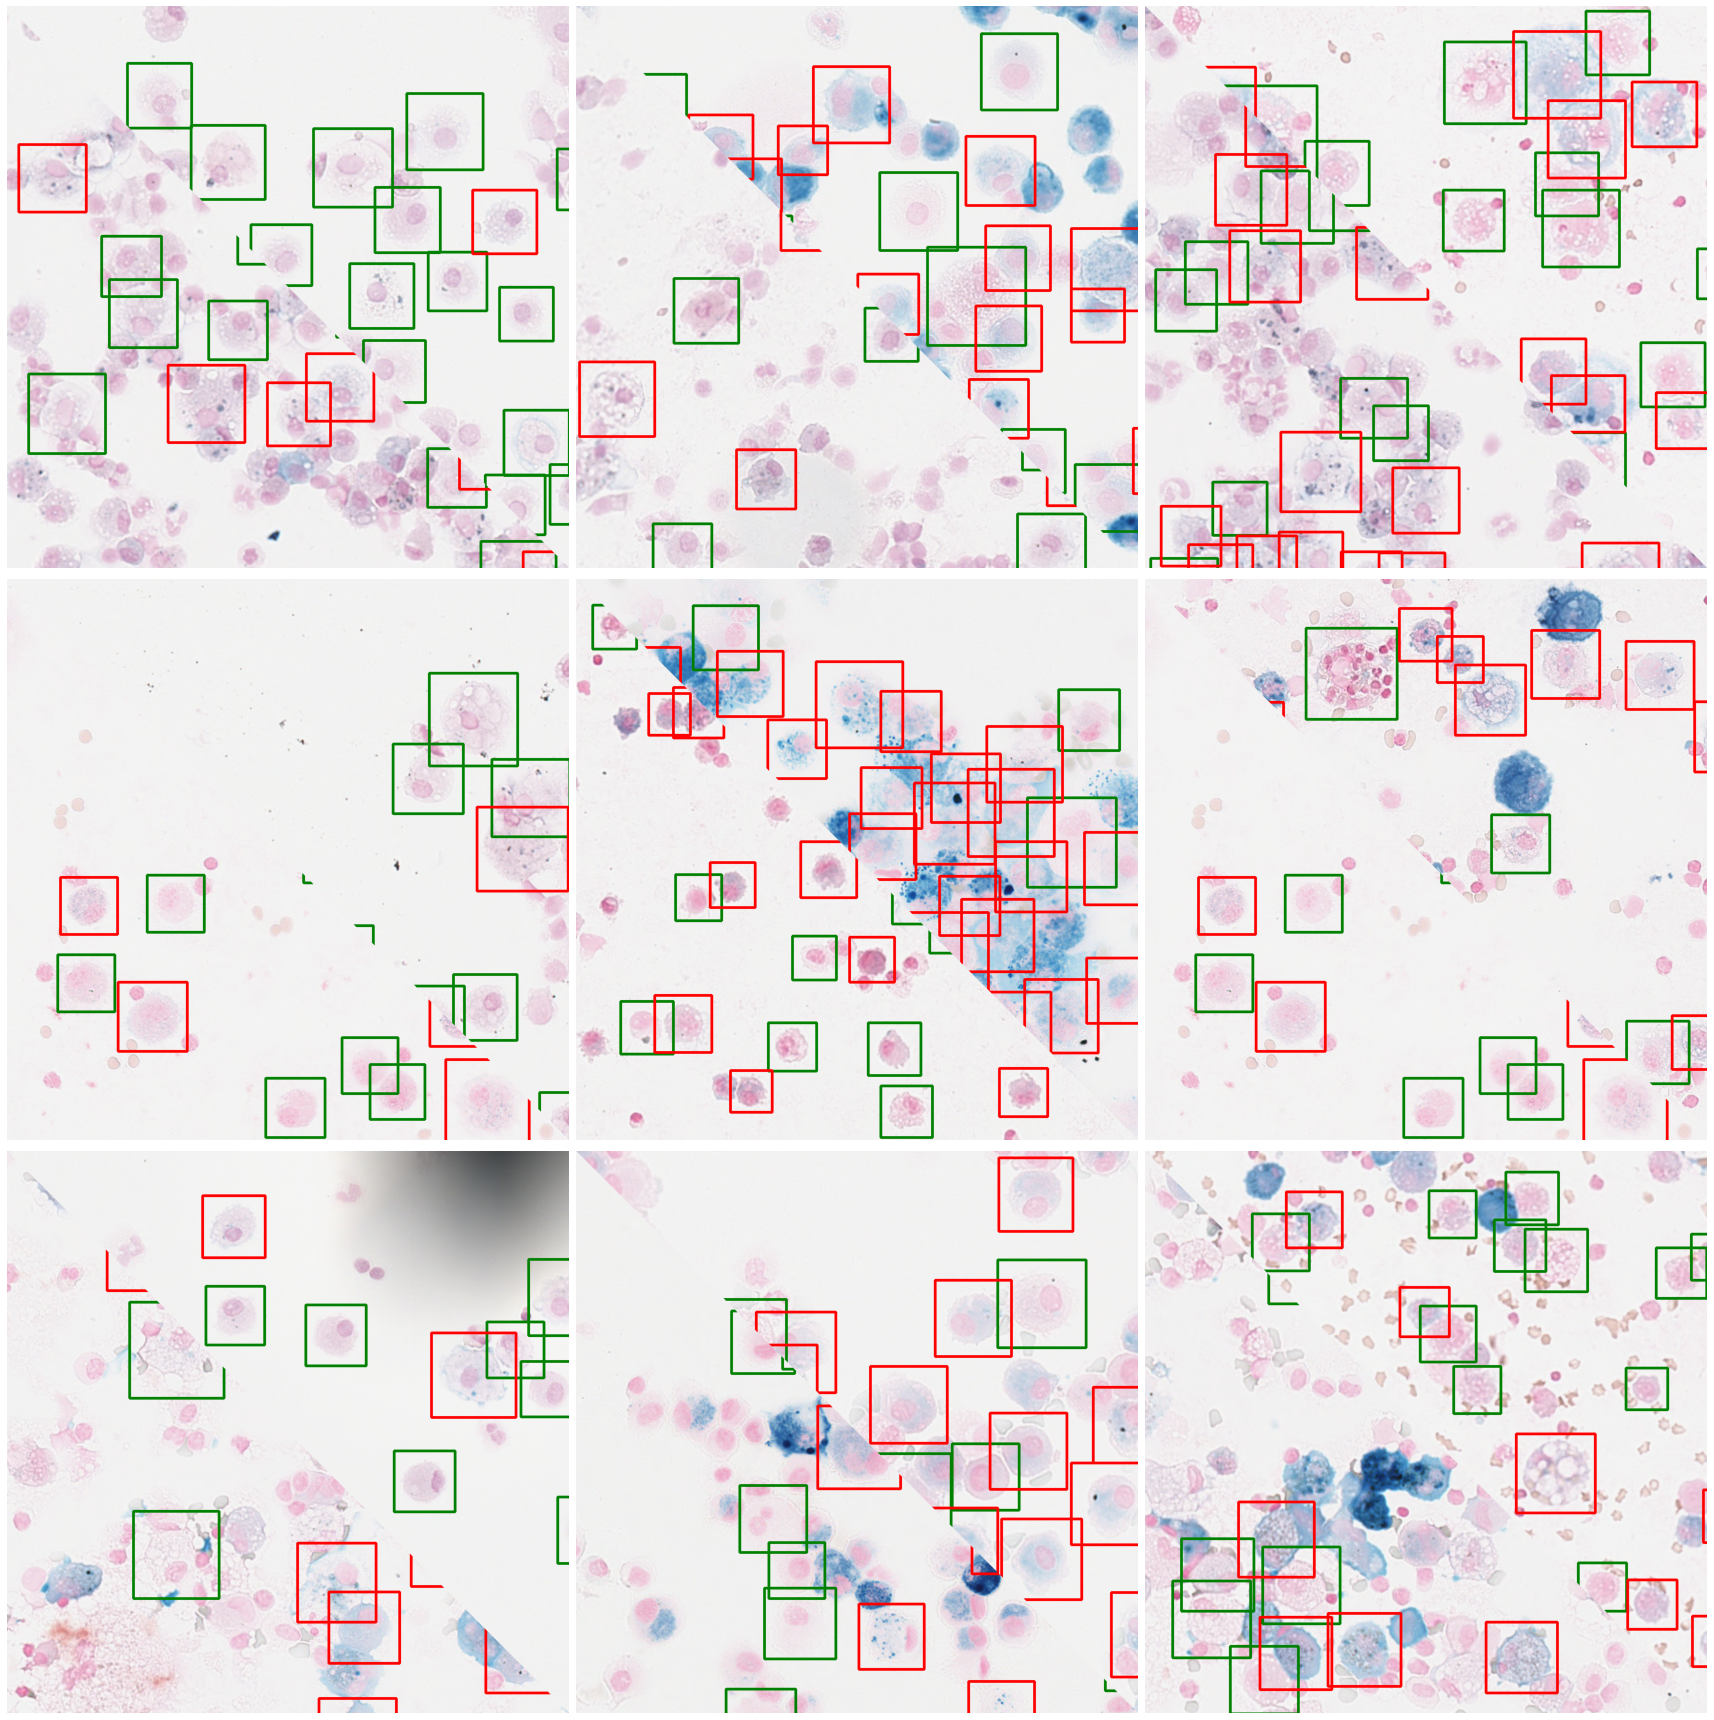

In [161]:
fig, axs = plt.subplots(3, 3, figsize=(24,24))


cat_train = extract_information(cat_train, index=0)
cat_val = extract_information(cat_val, index=0)
equine_train = extract_information(equine_train, index=0)
equine_val = extract_information(equine_val, index=0)
human_train = extract_information(human_train, index=0)
human_val = extract_information(human_val, index=0)

# first row

axs[0, 0].imshow(create_split_image(cat_val["BAL_Cat_Turnbull blue_1.svs"], 
                                    cat_train["BAL_Cat_Turnbull blue_13.svs"]))
axs[0, 0].axis('off')

cat_val = extract_information(cat_val, index=1)
axs[0, 1].imshow(create_split_image(cat_val["BAL_Cat_Turnbull blue_10.svs"], 
                                    human_train["2707_20 TB BAL Human neu.svs"]))
axs[0, 1].axis('off')

axs[0, 2].imshow(create_split_image(cat_val["BAL_Cat_Turnbull blue_1.svs"], 
                                    equine_train["03_EIPH_566933 R Turnbull blue.svs"]))
axs[0, 2].axis('off')

#second row
axs[1, 0].imshow(create_split_image(equine_val["07_EIPH_574882 left lung Turnbull blue.svs"], 
                                    cat_train["BAL_Cat_Turnbull blue_6.svs"]))
axs[1, 0].axis('off')

axs[1, 1].imshow(create_split_image(equine_val["31_EIPH_568354 Berliner Blau.svs"], 
                                    human_train["10080_19 humane BAL Berliner Blau-001.svs"]))
axs[1, 1].axis('off')

equine_val = extract_information(equine_val, index=0)
equine_train = extract_information(equine_train, index=0)
axs[1, 2].imshow(create_split_image(equine_val["07_EIPH_574882 left lung Turnbull blue.svs"], 
                                    equine_train["22_EIPH_575216 Turnbull blue.svs"]))
axs[1, 2].axis('off')

#third row
axs[2, 0].imshow(create_split_image(human_val["11480_19 humane BAL Berliner Blau.svs"], 
                                    cat_train["BAL_Cat_Turnbull blue_12.svs"]))
axs[2, 0].axis('off')

axs[2, 1].imshow(create_split_image(human_val["2702_20 BB Human BAL-001.svs"], 
                                    human_train["10227_19 humane BAL Berliner Blau.svs"]))
axs[2, 1].axis('off')

human_val = extract_information(human_val, index=1)
axs[2, 2].imshow(create_split_image(human_val["11480_19 humane BAL Berliner Blau.svs"], 
                                    equine_train["27_EIPH_571557 berliner blau.svs"]))
axs[2, 2].axis('off')


fig.tight_layout()

fig.savefig("SpeciesConfusionMatrix.pdf")